## Overview
The Business Operations function at XYZ plays a central role in Operations. Our aim is to
create a world-class Operations, which delivers the most reliable customer service
experience and contributes to the best value proposition. As a data-driven company, the
Business Intelligence Analyst will be key in supporting our goal and help us take the right
business decisions


### Problem Statement

The 1st Line Financial Crime team, which is part of the Business Operations team, is
responsible for protecting Kroo and its customers from fraudulent activities. You’ve been
asked by your line manager to have a look and analyse a sample of mock customer data
and share your findings with the Heads of Fincrime and Compliance.
1. Propose a model for assessing customer risk level (High/Medium/Low)(assume fraud
confirmed means confirmed that the customers are bad actors). How did you get to
your conclusion? What other attributes would you suggest us could consider?


## Approach
1. Exploring and Cleaning Data
2. Applying PCA to reduce dimension
3. Clusturing data into 3 groups
4. Identifying type of cluster by exploring data
5. Creating ML model to classify customer

## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
path = "path to files"

# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from ipywidgets import interact

# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')

import pickle
import os

In [4]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline, make_pipeline

# Tuning
from sklearn.model_selection import GridSearchCV


# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, LabelEncoder

# Importing Data

In [5]:
data = pd.read_excel(path+"BI_-_Case_Study_Data.xlsx")
print(data.shape)
data.tail()

(216, 14)


,Post code,ID Type,Email,Location,Numer of Devices,Age,Crypto Use,ATM use,Declared Use,Declated Turnover,Actual Use,Actual turnover,Months Active,Fraud Confirmed
211,W32,Driving licence Full,elinore.swaniawski@sbcglobal.net,UK,1.0,21.0,YES,NO,Receiving and Withdrawing,50k,ATM,40k,1.0,NO
212,W33,Driving licence Provisional,fheller@yahoo.com,Europe,1.0,22.0,NO,NO,Day to date,20k,Friends and Family,20k,2.0,NO
213,W34,Driving licence Provisional,predovic.syble@icloud.com,Other,3.0,21.0,NO,NO,Day to date,20k,Receiving and Withdrawing,70k,1.0,NO
214,W35,Passport,hahn.vivienne@comcast.net,High Risk Coutry,2.0,27.0,NO,YES,ATM,20k,ATM,100k,1.0,NO
215,W36,Passport,volkman.augustine@hotmail.com,High Risk Coutry,3.0,25.0,NO,YES,ATM,30k,ATM,60k,1.0,NO


In [6]:
data.columns

Index(['Post code', 'ID Type', 'Email ', 'Location', 'Numer of Devices', 'Age',
       'Crypto Use', 'ATM use', 'Declared Use', 'Declated Turnover',
       'Actual Use', 'Actual turnover ', 'Months Active', 'Fraud Confirmed'],
      dtype='object')

In [7]:
print(data.shape)

(216, 14)


Declated Turnover is a typo. <br>
It must be Declared Turnover,<br>
Email and Actual Turnover has space in the end <br>Let's Fix that.

In [8]:
data.rename(columns = {'Declated Turnover':'Declared Turnover' ,
                       'Email ': 'Email' ,
                       'Actual turnover ':'Actual Turnover',
                       'Numer of Devices' : 'Number of Devices'},
                        inplace = True)
data.columns

Index(['Post code', 'ID Type', 'Email', 'Location', 'Number of Devices', 'Age',
       'Crypto Use', 'ATM use', 'Declared Use', 'Declared Turnover',
       'Actual Use', 'Actual Turnover', 'Months Active', 'Fraud Confirmed'],
      dtype='object')

# About Data

- We have 216 rows and 14 columns in the dataset

# Data Cleaning

## Duplicated data

In [9]:
data.duplicated().sum()

0

## Handling Missing Values

In [10]:
data.isna().sum()

Post code            0
ID Type              0
Email                0
Location             0
Number of Devices    0
Age                  1
Crypto Use           0
ATM use              0
Declared Use         0
Declared Turnover    0
Actual Use           0
Actual Turnover      0
Months Active        0
Fraud Confirmed      0
dtype: int64

There is one column 'Age' having only 1 value.

In [11]:
data["Age"].value_counts()

21.0    38
18.0    37
22.0    23
25.0    18
19.0    16
27.0    12
35.0    11
23.0     7
37.0     6
31.0     6
26.0     6
33.0     5
56.0     3
28.0     3
34.0     3
43.0     3
53.0     3
75.0     2
60.0     2
32.0     2
57.0     2
65.0     2
62.0     2
61.0     2
20.0     1
Name: Age, dtype: int64

As there no such columns that can relate to age <br>
Also Most of the age values are 21 <br>
Hence Filling missing age value by 21 <br>
Converting Age to int 

In [12]:
data["Age"].fillna(21 , inplace= True)
data['Age'] = data['Age'].astype(int)

# Data Cleaning

In [13]:
data.nunique().sort_values()

Crypto Use             2
ATM use                2
Fraud Confirmed        2
Location               4
Declared Use           4
Actual Use             4
ID Type                5
Number of Devices      6
Declared Turnover      8
Actual Turnover        8
Months Active         10
Age                   25
Post code             36
Email                216
dtype: int64

In [14]:
categCols = data.nunique().sort_values()[data.nunique().sort_values() <= 8 ].index.values
categCols

array(['Crypto Use', 'ATM use', 'Fraud Confirmed', 'Location',
       'Declared Use', 'Actual Use', 'ID Type', 'Number of Devices',
       'Declared Turnover', 'Actual Turnover'], dtype=object)

In [15]:
for i in categCols:
    print(i , data[i].unique())

Crypto Use ['YES' 'NO']
ATM use ['NO' 'YES']
Fraud Confirmed ['NO' 'YES']
Location ['UK ' 'Europe ' 'Other' 'High Risk Coutry']
Declared Use ['Day to date' 'ATM' 'Friends and Family' 'Receiving and Withdrawing']
Actual Use ['Day to date' 'ATM' 'Friends and Family' 'Receiving and Withdrawing']
ID Type ['Passport ' 'ID Card' 'Residence permit ' 'Driving licence Full'
 'Driving licence Provisional']
Number of Devices [3. 1. 2. 5. 6. 4.]
Declared Turnover ['20K' '30k' '40k' '20k' '70k' '100k' '60k' '50k']
Actual Turnover ['20K' '30k' '40k' '20k' '70k' '100k' '60k' '50k']


Turnover coulmns have values in string datatype.
Let's Convert them into int and not treat them as categorical.

In [16]:
data.dtypes

Post code             object
ID Type               object
Email                 object
Location              object
Number of Devices    float64
Age                    int64
Crypto Use            object
ATM use               object
Declared Use          object
Declared Turnover     object
Actual Use            object
Actual Turnover       object
Months Active        float64
Fraud Confirmed       object
dtype: object

In [17]:
data["Declared Turnover"] = data["Declared Turnover"].str.replace('k', '', case=False).astype(int)
data["Actual Turnover"] = data["Actual Turnover"].str.replace('k', '', case=False).astype(int)

In [18]:
for i in categCols:
    print(i , data[i].unique())

Crypto Use ['YES' 'NO']
ATM use ['NO' 'YES']
Fraud Confirmed ['NO' 'YES']
Location ['UK ' 'Europe ' 'Other' 'High Risk Coutry']
Declared Use ['Day to date' 'ATM' 'Friends and Family' 'Receiving and Withdrawing']
Actual Use ['Day to date' 'ATM' 'Friends and Family' 'Receiving and Withdrawing']
ID Type ['Passport ' 'ID Card' 'Residence permit ' 'Driving licence Full'
 'Driving licence Provisional']
Number of Devices [3. 1. 2. 5. 6. 4.]
Declared Turnover [ 20  30  40  70 100  60  50]
Actual Turnover [ 20  30  40  70 100  60  50]


In [19]:
categCols = data.nunique().sort_values()[data.nunique().sort_values() < 6 ].index.values
categCols

array(['Crypto Use', 'ATM use', 'Fraud Confirmed', 'Location',
       'Declared Use', 'Actual Use', 'ID Type'], dtype=object)

# Looking into Data

### 1. Is there any specific age group who is attempting more frauds ?
### 2. Does difference between actual turnover and declared turnover say something about fraud ?
### 3. Does Actual use and declared use say something about fraud ?
### 4. Is Email Domain related to fraud ?

## Fruad Ratio in Data 

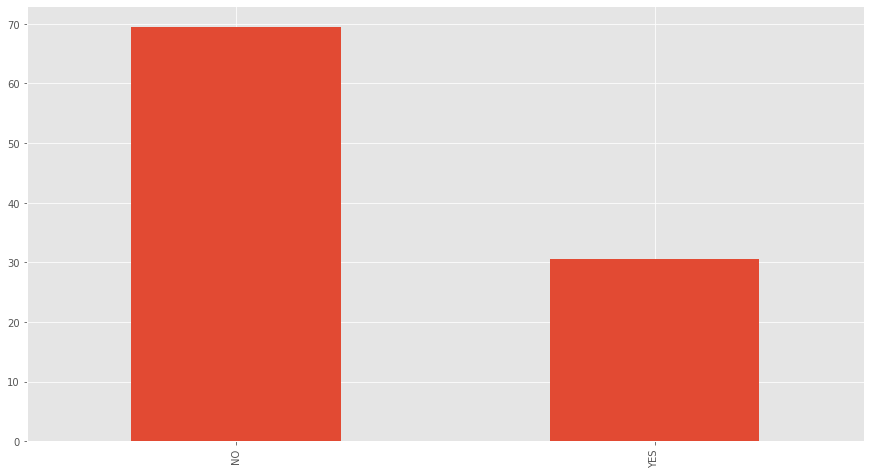

In [20]:
plt.figure(figsize=((15,8)))
fraud_data = data['Fraud Confirmed'].value_counts(normalize=True).mul(100).round(2)
fraud_data.plot.bar()
plt.show()

#### In the given dataset 70% of the customer are loyal and with 30% of customers , Fraud is confirmed.
#### Data is not balanced across all the class_types.
#### Model performance will be affected due to imbalanced data set.
#### Model may perform poor.
#### Data can be balanced using SMOTE and more data can be added using bootstrap.

## 1. Is there any specific age group who is attempting more frauds ?

<Figure size 1080x576 with 0 Axes>

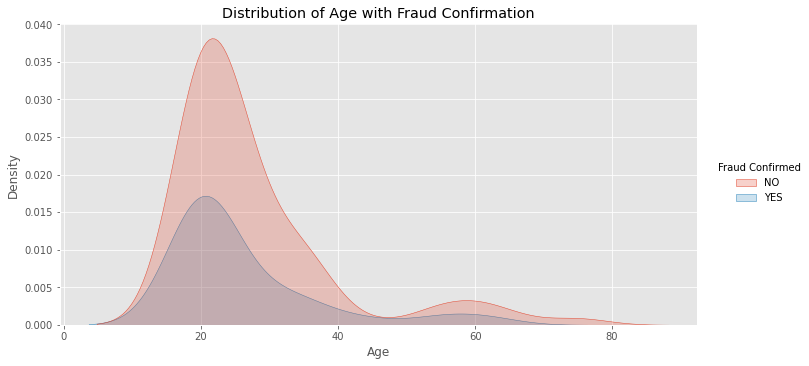

In [21]:
plt.figure(figsize=((15,8)))
sns.displot(data = data, x= "Age",hue="Fraud Confirmed",fill=True, kind ="kde", height=5, aspect=2)
plt.title("Distribution of Age with Fraud Confirmation")
plt.show()

In [22]:
data["Age"].describe()

count    216.000000
mean      26.990741
std       11.728316
min       18.000000
25%       20.750000
50%       22.000000
75%       28.750000
max       75.000000
Name: Age, dtype: float64

In [23]:
bins = [0, 30, 40, 50, 60, 70, np.inf]
names = ['<30','30-40', '40-50','50-60','60-70','70+']
data['AgeRange'] = pd.cut(data['Age'], bins, labels=names)

In [24]:
data['AgeRange'].value_counts()

<30      162
30-40     33
50-60     10
60-70      6
40-50      3
70+        2
Name: AgeRange, dtype: int64

In [25]:
data[data['Fraud Confirmed'] == 'YES']['AgeRange'].value_counts()

<30      50
30-40     9
50-60     3
40-50     2
60-70     2
70+       0
Name: AgeRange, dtype: int64

In [26]:
AgeData = pd.DataFrame({'AgeRangeCount' :data['AgeRange'].value_counts().values,
              'AgeRangeCountFraud' : data[data['Fraud Confirmed'] == 'YES']['AgeRange'].value_counts().values},
             index= data['AgeRange'].value_counts().index)
AgeData

,AgeRangeCount,AgeRangeCountFraud
<30,162,50
30-40,33,9
50-60,10,3
60-70,6,2
40-50,3,2
70+,2,0


In [27]:
AgeData['FraudPerc'] = AgeData['AgeRangeCountFraud']/AgeData['AgeRangeCount']

In [28]:
AgeData

,AgeRangeCount,AgeRangeCountFraud,FraudPerc
<30,162,50,0.308642
30-40,33,9,0.272727
50-60,10,3,0.300000
60-70,6,2,0.333333
40-50,3,2,0.666667
70+,2,0,0.000000


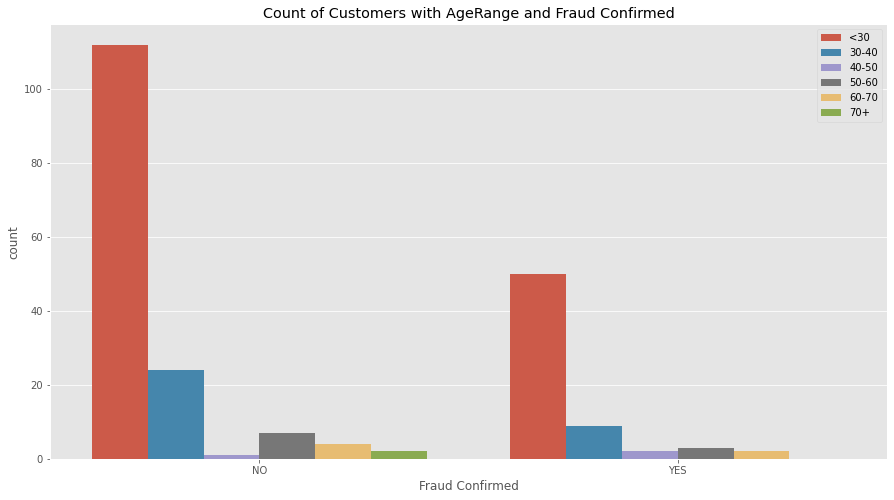

In [29]:
plt.figure(figsize=((15,8)))
ax = sns.countplot( x = 'Fraud Confirmed', hue = "AgeRange", data = data)
plt.title(f"Count of Customers with AgeRange and Fraud Confirmed")
plt.legend(loc = 'upper right')
plt.show()

### Since data is not balanced amongst the age group. <br> From the above graphs and present data, we can say that nearly 30% of customers have been confirmed with fraud in all the age range.

## 2. Does difference between actual turnover and declared turnover say something about fraud ?

In [30]:

def f(row):
    if row['Actual Turnover'] < row['Declared Turnover']:
        val = 'Low'
    elif row['Actual Turnover'] > row['Declared Turnover']:
        val = 'High'
    else:
        val = 'Same'
    return val


data['TurnoverDiffStatus'] = data.apply(f, axis=1)
data['TurnoverDiff'] = abs(data['Actual Turnover'] - data['Declared Turnover'])

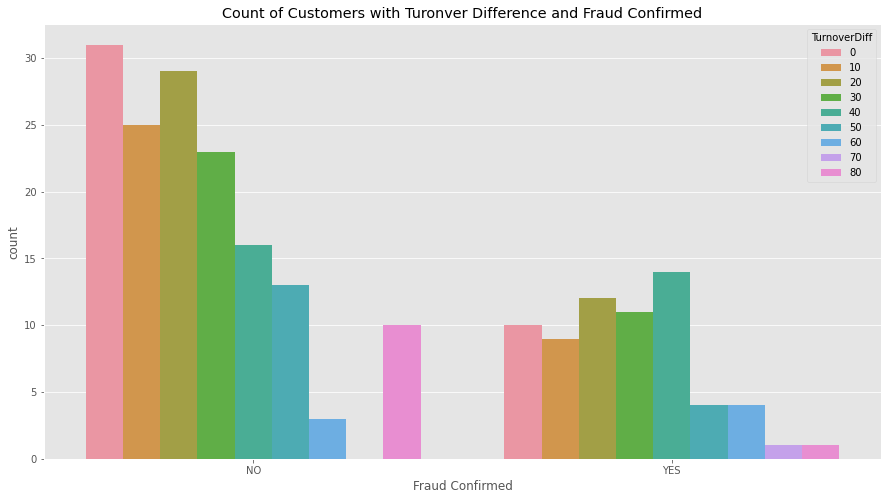

In [31]:
plt.figure(figsize=((15,8)))
ax = sns.countplot( x = 'Fraud Confirmed', hue = 'TurnoverDiff' , data = data)
plt.title(f"Count of Customers with Turonver Difference and Fraud Confirmed")
plt.show()

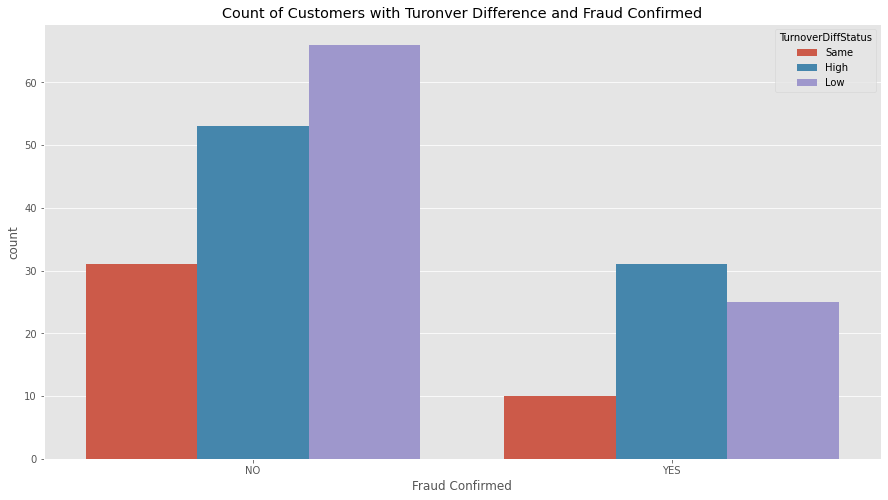

In [32]:
plt.figure(figsize=((15,8)))
ax = sns.countplot( x = 'Fraud Confirmed', hue = 'TurnoverDiffStatus' , data = data)
plt.title(f"Count of Customers with Turonver Difference and Fraud Confirmed")
plt.show()

#### From Above plot we can conclude that Customer having Actual Turnover higher or lower than Declared Turnover by 0 to 30k are more likely to attempt a fraud

## 3. Does Actual use and declared use say something about fraud ?¶

In [33]:
data['AccUseDiff'] = np.where(data['Actual Use'] == data['Declared Use'], 'No', 'Yes')

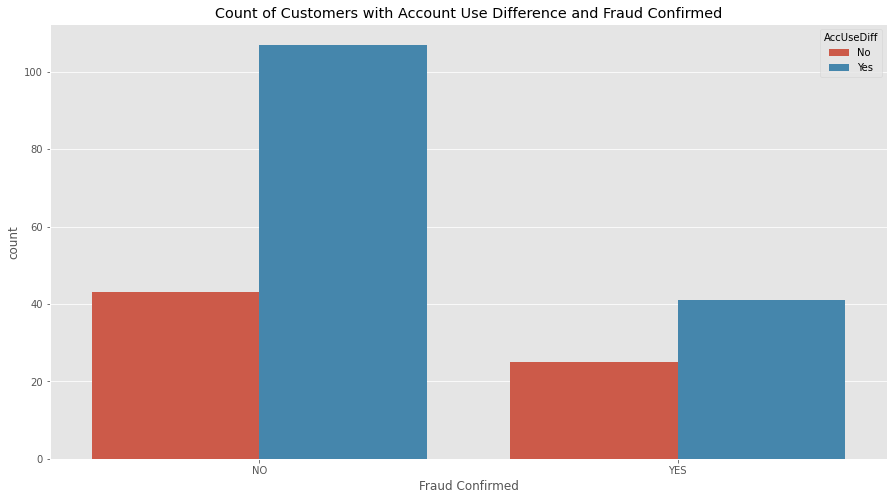

In [34]:
plt.figure(figsize=((15,8)))
ax = sns.countplot( x = 'Fraud Confirmed', hue = 'AccUseDiff' , data = data)
plt.title(f"Count of Customers with Account Use Difference and Fraud Confirmed")
plt.show()

In [35]:
AccUseData = pd.DataFrame({'ActualUseCount' :data['Actual Use'].value_counts().values,
              'ActualUseCountFraud' : data[data['Fraud Confirmed'] == 'YES']['Actual Use'].value_counts().values,
               'DeclaredUseCount' :data['Declared Use'].value_counts().values,
              'DeclaredUseCountFraud' : data[data['Fraud Confirmed'] == 'YES']['Declared Use'].value_counts().values,        
                       },
             index= data['Actual Use'].value_counts().index)
AccUseData

,ActualUseCount,ActualUseCountFraud,DeclaredUseCount,DeclaredUseCountFraud
ATM,125,31,75,22
Day to date,39,13,71,20
Friends and Family,26,11,52,18
Receiving and Withdrawing,26,11,18,6


In [36]:
AccUseData['ActualUseFraudPerc'] = AccUseData['ActualUseCountFraud'] / AccUseData['ActualUseCount']
AccUseData['DeclaredUseFraudPerc'] = AccUseData['DeclaredUseCountFraud'] / AccUseData['DeclaredUseCount']
AccUseData

,ActualUseCount,ActualUseCountFraud,DeclaredUseCount,DeclaredUseCountFraud,ActualUseFraudPerc,DeclaredUseFraudPerc
ATM,125,31,75,22,0.248000,0.293333
Day to date,39,13,71,20,0.333333,0.281690
Friends and Family,26,11,52,18,0.423077,0.346154
Receiving and Withdrawing,26,11,18,6,0.423077,0.333333


### From the above results it is clear that customers with account use as "Friends and Family" and "Receiveing and Withdrawing" have more frauds confirmed.

## 7. Is Email Domain related to fraud ?

In [37]:
data["EmailDomain"] = data["Email"].str.split("@", 1, expand=True)[1]

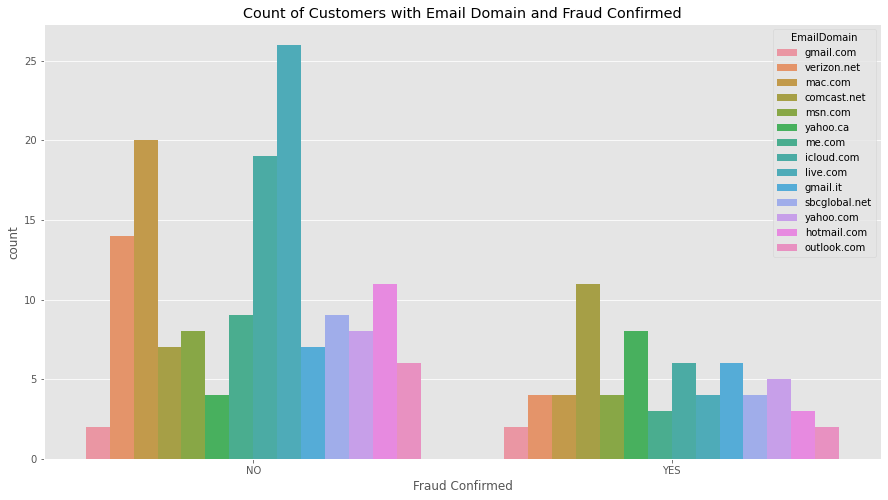

In [38]:
plt.figure(figsize=((15,8)))
ax = sns.countplot( x = 'Fraud Confirmed', hue = 'EmailDomain' , data = data)
plt.title(f"Count of Customers with Email Domain and Fraud Confirmed")
plt.show()

In [39]:
EmailDomainData = pd.DataFrame({'EmailDomainCount' :data['EmailDomain'].value_counts().values,
              'EmailDomainCountFraud' : data[data['Fraud Confirmed'] == 'YES']['EmailDomain'].value_counts().values,
                    
                       },
             index= data['EmailDomain'].value_counts().index)
EmailDomainData

,EmailDomainCount,EmailDomainCountFraud
live.com,30,11
icloud.com,25,8
mac.com,24,6
verizon.net,18,6
comcast.net,18,5
hotmail.com,14,4
gmail.it,13,4
sbcglobal.net,13,4
yahoo.com,13,4
msn.com,12,4


In [40]:
EmailDomainData['FraudPerc'] = EmailDomainData['EmailDomainCountFraud']/EmailDomainData['EmailDomainCount']
EmailDomainData.sort_values(by='FraudPerc' , ascending=False)

,EmailDomainCount,EmailDomainCountFraud,FraudPerc
gmail.com,4,2,0.500000
live.com,30,11,0.366667
verizon.net,18,6,0.333333
msn.com,12,4,0.333333
icloud.com,25,8,0.320000
gmail.it,13,4,0.307692
sbcglobal.net,13,4,0.307692
yahoo.com,13,4,0.307692
hotmail.com,14,4,0.285714
comcast.net,18,5,0.277778


### Customers with Email domain as "gmail.com and live.com" are more with comfirmed fraud. <br>Where there are more than 25% of customers from all other email domains who have comfirmed with fraud.

### Saving Cleaned Data

In [41]:
data.to_csv(path+"Cleaned_Data.csv", index=False)

## Data Preprocessing

In [42]:
cleaned_data = pd.read_csv(path+"Cleaned_Data.csv")
cleaned_data

,Post code,ID Type,Email,Location,Number of Devices,Age,Crypto Use,ATM use,Declared Use,Declared Turnover,Actual Use,Actual Turnover,Months Active,Fraud Confirmed,AgeRange,TurnoverDiffStatus,TurnoverDiff,AccUseDiff,EmailDomain
0,W1,Passport,jbrekke@gmail.com,UK,3.0,18,YES,NO,Day to date,20,Day to date,20,12.0,NO,<30,Same,0,No,gmail.com
1,W2,Passport,sid23@verizon.net,Europe,3.0,19,YES,NO,Day to date,20,Day to date,30,3.0,NO,<30,High,10,No,verizon.net
2,W3,Passport,wstark@mac.com,Other,3.0,20,YES,NO,Day to date,20,Day to date,40,3.0,NO,<30,High,20,No,mac.com
3,W4,Passport,haven.gottlieb@comcast.net,High Risk Coutry,1.0,18,YES,NO,Day to date,20,ATM,20,3.0,YES,<30,Same,0,Yes,comcast.net
4,W5,ID Card,qheidenreich@msn.com,High Risk Coutry,1.0,18,NO,NO,Day to date,30,ATM,70,2.0,YES,<30,High,40,Yes,msn.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,W32,Driving licence Full,elinore.swaniawski@sbcglobal.net,UK,1.0,21,YES,NO,Receiving and Withdrawing,50,ATM,40,1.0,NO,<30,Low,10,Yes,sbcglobal.net
212,W33,Driving licence Provisional,fheller@yahoo.com,Europe,1.0,22,NO,NO,Day to date,20,Friends and Family,20,2.0,NO,<30,Same,0,Yes,yahoo.com
213,W34,Driving licence Provisional,predovic.syble@icloud.com,Other,3.0,21,NO,NO,Day to date,20,Receiving and Withdrawing,70,1.0,NO,<30,High,50,Yes,icloud.com
214,W35,Passport,hahn.vivienne@comcast.net,High Risk Coutry,2.0,27,NO,YES,ATM,20,ATM,100,1.0,NO,<30,High,80,No,comcast.net


In [43]:
cleaned_data.nunique().sort_values()

Crypto Use              2
ATM use                 2
AccUseDiff              2
Fraud Confirmed         2
TurnoverDiffStatus      3
Location                4
Declared Use            4
Actual Use              4
ID Type                 5
Number of Devices       6
AgeRange                6
Declared Turnover       7
Actual Turnover         7
TurnoverDiff            9
Months Active          10
EmailDomain            14
Age                    25
Post code              36
Email                 216
dtype: int64

In [44]:
categCols = cleaned_data.nunique().sort_values()[cleaned_data.nunique().sort_values() < 6 ].index.values
categCols = categCols

In [45]:
# Removing cluster from above as it is target variable
categCols = np.delete(categCols, np.where(categCols == "Cluster"))
categCols

array(['Crypto Use', 'ATM use', 'AccUseDiff', 'Fraud Confirmed',
       'TurnoverDiffStatus', 'Location', 'Declared Use', 'Actual Use',
       'ID Type'], dtype=object)

In [46]:
for i in categCols:
    print(i , cleaned_data[i].unique())

Crypto Use ['YES' 'NO']
ATM use ['NO' 'YES']
AccUseDiff ['No' 'Yes']
Fraud Confirmed ['NO' 'YES']
TurnoverDiffStatus ['Same' 'High' 'Low']
Location ['UK ' 'Europe ' 'Other' 'High Risk Coutry']
Declared Use ['Day to date' 'ATM' 'Friends and Family' 'Receiving and Withdrawing']
Actual Use ['Day to date' 'ATM' 'Friends and Family' 'Receiving and Withdrawing']
ID Type ['Passport ' 'ID Card' 'Residence permit ' 'Driving licence Full'
 'Driving licence Provisional']


### Converting categorical columns to numeric

In [48]:
numeric_data = cleaned_data.copy()
encoded_categories = ""
for i in categCols:
    le = LabelEncoder()
    print(i)
    numeric_data[i+'_new'] = le.fit_transform(numeric_data[i])
    numeric_data[i+'_new'] = le.transform(numeric_data[i])
    print({l: i for i, l in enumerate(le.classes_)})
    encoded_categories = encoded_categories + i+"="+ str({l: i for i, l in enumerate(le.classes_)})

Crypto Use
{'NO': 0, 'YES': 1}
ATM use
{'NO': 0, 'YES': 1}
AccUseDiff
{'No': 0, 'Yes': 1}
Fraud Confirmed
{'NO': 0, 'YES': 1}
TurnoverDiffStatus
{'High': 0, 'Low': 1, 'Same': 2}
Location
{'Europe ': 0, 'High Risk Coutry': 1, 'Other': 2, 'UK ': 3}
Declared Use
{'ATM': 0, 'Day to date': 1, 'Friends and Family': 2, 'Receiving and Withdrawing': 3}
Actual Use
{'ATM': 0, 'Day to date': 1, 'Friends and Family': 2, 'Receiving and Withdrawing': 3}
ID Type
{'Driving licence Full': 0, 'Driving licence Provisional': 1, 'ID Card': 2, 'Passport ': 3, 'Residence permit ': 4}


In [49]:
numeric_data.shape 

(216, 28)

In [50]:
numeric_data.columns

Index(['Post code', 'ID Type', 'Email', 'Location', 'Number of Devices', 'Age',
       'Crypto Use', 'ATM use', 'Declared Use', 'Declared Turnover',
       'Actual Use', 'Actual Turnover', 'Months Active', 'Fraud Confirmed',
       'AgeRange', 'TurnoverDiffStatus', 'TurnoverDiff', 'AccUseDiff',
       'EmailDomain', 'Crypto Use_new', 'ATM use_new', 'AccUseDiff_new',
       'Fraud Confirmed_new', 'TurnoverDiffStatus_new', 'Location_new',
       'Declared Use_new', 'Actual Use_new', 'ID Type_new'],
      dtype='object')

In [51]:
## Dropping the old columns
numeric_data.drop(categCols ,axis=1, inplace=True)

In [52]:
numeric_data.columns = numeric_data.columns.str.replace('_new', '')
numeric_data.columns

Index(['Post code', 'Email', 'Number of Devices', 'Age', 'Declared Turnover',
       'Actual Turnover', 'Months Active', 'AgeRange', 'TurnoverDiff',
       'EmailDomain', 'Crypto Use', 'ATM use', 'AccUseDiff', 'Fraud Confirmed',
       'TurnoverDiffStatus', 'Location', 'Declared Use', 'Actual Use',
       'ID Type'],
      dtype='object')

In [53]:
numeric_data.tail()

,Post code,Email,Number of Devices,Age,Declared Turnover,Actual Turnover,Months Active,AgeRange,TurnoverDiff,EmailDomain,Crypto Use,ATM use,AccUseDiff,Fraud Confirmed,TurnoverDiffStatus,Location,Declared Use,Actual Use,ID Type
211,W32,elinore.swaniawski@sbcglobal.net,1.0,21,50,40,1.0,<30,10,sbcglobal.net,1,0,1,0,1,3,3,0,0
212,W33,fheller@yahoo.com,1.0,22,20,20,2.0,<30,0,yahoo.com,0,0,1,0,2,0,1,2,1
213,W34,predovic.syble@icloud.com,3.0,21,20,70,1.0,<30,50,icloud.com,0,0,1,0,0,2,1,3,1
214,W35,hahn.vivienne@comcast.net,2.0,27,20,100,1.0,<30,80,comcast.net,0,1,0,0,0,1,0,0,3
215,W36,volkman.augustine@hotmail.com,3.0,25,30,60,1.0,<30,30,hotmail.com,0,1,0,0,0,1,0,0,3


In [54]:
numeric_data.dtypes

Post code              object
Email                  object
Number of Devices     float64
Age                     int64
Declared Turnover       int64
Actual Turnover         int64
Months Active         float64
AgeRange               object
TurnoverDiff            int64
EmailDomain            object
Crypto Use              int64
ATM use                 int64
AccUseDiff              int64
Fraud Confirmed         int64
TurnoverDiffStatus      int64
Location                int64
Declared Use            int64
Actual Use              int64
ID Type                 int64
dtype: object

In [55]:
# Dropping columns Email, Email Domain and Age Range
# Remove W from post code
numeric_data.drop(["Post code","Email" , "EmailDomain", "AgeRange"] , axis=1 , inplace=True)
# numeric_data["Post code"] = numeric_data["Post code"].str.replace('w', '', case=False).astype(int)

In [56]:
numeric_data.head()

,Number of Devices,Age,Declared Turnover,Actual Turnover,Months Active,TurnoverDiff,Crypto Use,ATM use,AccUseDiff,Fraud Confirmed,TurnoverDiffStatus,Location,Declared Use,Actual Use,ID Type
0,3.0,18,20,20,12.0,0,1,0,0,0,2,3,1,1,3
1,3.0,19,20,30,3.0,10,1,0,0,0,0,0,1,1,3
2,3.0,20,20,40,3.0,20,1,0,0,0,0,2,1,1,3
3,1.0,18,20,20,3.0,0,1,0,1,1,2,1,1,0,3
4,1.0,18,30,70,2.0,40,0,0,1,1,0,1,1,0,2


# Saving Numeric Data

In [57]:
numeric_data.to_csv(path+"Numeric_Data.csv", index=False)

# Clustering using PCA + Kmeans

In [58]:
numeric_data = pd.read_csv(path+"Numeric_Data.csv")
numeric_data

,Number of Devices,Age,Declared Turnover,Actual Turnover,Months Active,TurnoverDiff,Crypto Use,ATM use,AccUseDiff,Fraud Confirmed,TurnoverDiffStatus,Location,Declared Use,Actual Use,ID Type
0,3.0,18,20,20,12.0,0,1,0,0,0,2,3,1,1,3
1,3.0,19,20,30,3.0,10,1,0,0,0,0,0,1,1,3
2,3.0,20,20,40,3.0,20,1,0,0,0,0,2,1,1,3
3,1.0,18,20,20,3.0,0,1,0,1,1,2,1,1,0,3
4,1.0,18,30,70,2.0,40,0,0,1,1,0,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1.0,21,50,40,1.0,10,1,0,1,0,1,3,3,0,0
212,1.0,22,20,20,2.0,0,0,0,1,0,2,0,1,2,1
213,3.0,21,20,70,1.0,50,0,0,1,0,0,2,1,3,1
214,2.0,27,20,100,1.0,80,0,1,0,0,0,1,0,0,3


In [59]:
X = numeric_data.loc[ : , numeric_data.columns != 'Fraud Confirmed'].copy() # Fraud Confirmed is our target variable
y = numeric_data['Fraud Confirmed'].copy()

In [60]:
# Standardizing the features
X_Scaled = StandardScaler().fit_transform(X)

### Applying PCA

In [61]:
pca = PCA()
principalComponents = pca.fit(X_Scaled)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['PC1', 'PC2'])

In [62]:
pca.explained_variance_ratio_

array([0.15459501, 0.12311267, 0.10202506, 0.08564923, 0.08031825,
       0.07675728, 0.07406424, 0.06273377, 0.05842285, 0.05231215,
       0.05044771, 0.03634111, 0.02681157, 0.0164091 ])

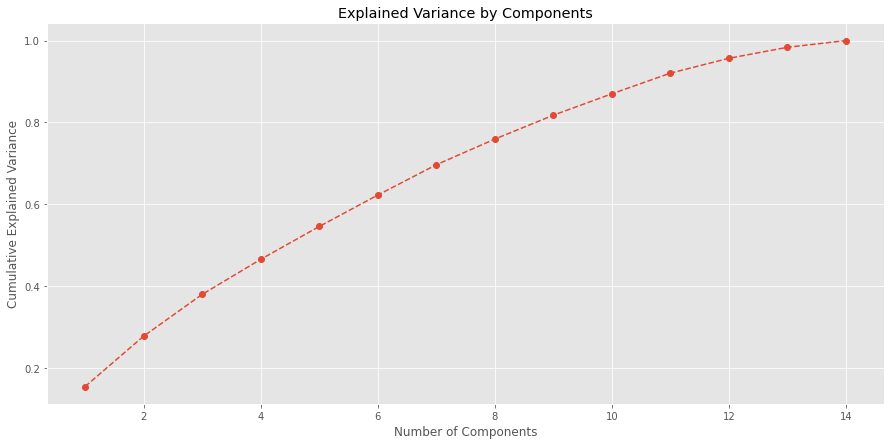

In [64]:
plt.figure(figsize = (15,7))
plt.plot(range(1,15), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [65]:
pca = PCA(n_components = 9)
pca.fit(X_Scaled)
pca.components_

array([[ 0.19485162, -0.20658042,  0.17855495,  0.51604326,  0.0124434 ,
         0.52642741, -0.00606687,  0.11672801,  0.18212617, -0.52712896,
        -0.06640516,  0.11380977,  0.0085517 , -0.04197199],
       [-0.19866168, -0.10993341,  0.44665321, -0.14646539, -0.18052674,
         0.12630089, -0.45604769,  0.51468542,  0.08741551,  0.23818478,
         0.07607814, -0.12357938, -0.08050441, -0.33787632],
       [-0.13755193,  0.24915675,  0.26076601, -0.12989412,  0.22620294,
         0.08035963,  0.1829484 , -0.08182679,  0.55188133,  0.20900829,
        -0.06500492,  0.61688254, -0.05750345,  0.00199372],
       [ 0.24800274, -0.07409526, -0.05138977, -0.0356663 ,  0.63088093,
        -0.12787516, -0.13380998,  0.19099406, -0.00230849,  0.05298091,
        -0.63508682, -0.14642436, -0.14734853, -0.10509821],
       [ 0.15744241, -0.12577069,  0.47906749, -0.27554682,  0.16880676,
         0.33576151,  0.10556384, -0.03651618, -0.28638537,  0.17034894,
         0.00286699, -0.09

In [66]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = X.columns,
              index = ['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9'])
df_pca_comp

,Number of Devices,Age,Declared Turnover,Actual Turnover,Months Active,TurnoverDiff,Crypto Use,ATM use,AccUseDiff,TurnoverDiffStatus,Location,Declared Use,Actual Use,ID Type
PC1,0.194852,-0.206580,0.178555,0.516043,0.012443,0.526427,-0.006067,0.116728,0.182126,-0.527129,-0.066405,0.113810,0.008552,-0.041972
PC2,-0.198662,-0.109933,0.446653,-0.146465,-0.180527,0.126301,-0.456048,0.514685,0.087416,0.238185,0.076078,-0.123579,-0.080504,-0.337876
PC3,-0.137552,0.249157,0.260766,-0.129894,0.226203,0.080360,0.182948,-0.081827,0.551881,0.209008,-0.065005,0.616883,-0.057503,0.001994
PC4,0.248003,-0.074095,-0.051390,-0.035666,0.630881,-0.127875,-0.133810,0.190994,-0.002308,0.052981,-0.635087,-0.146424,-0.147349,-0.105098
PC5,0.157442,-0.125771,0.479067,-0.275547,0.168807,0.335762,0.105564,-0.036516,-0.286385,0.170349,0.002867,-0.094545,0.266818,0.555949
PC6,-0.451314,0.181824,0.062063,0.100550,-0.076551,0.041088,-0.056655,-0.155876,-0.111776,-0.072732,-0.452350,-0.019924,0.673290,-0.195236
PC7,-0.326091,0.578463,0.174171,0.080752,0.164618,0.251766,0.235773,-0.018941,-0.242105,-0.116868,0.021447,-0.311819,-0.449493,-0.061218
PC8,0.575690,0.456272,0.071024,-0.011060,0.006078,-0.022319,0.066425,0.195841,-0.326824,0.021559,0.167731,0.247772,0.269367,-0.377581
PC9,-0.010378,0.459729,-0.335081,-0.048023,0.004847,0.103697,-0.511641,0.294686,0.149018,-0.149798,0.021971,0.046343,0.098221,0.507583


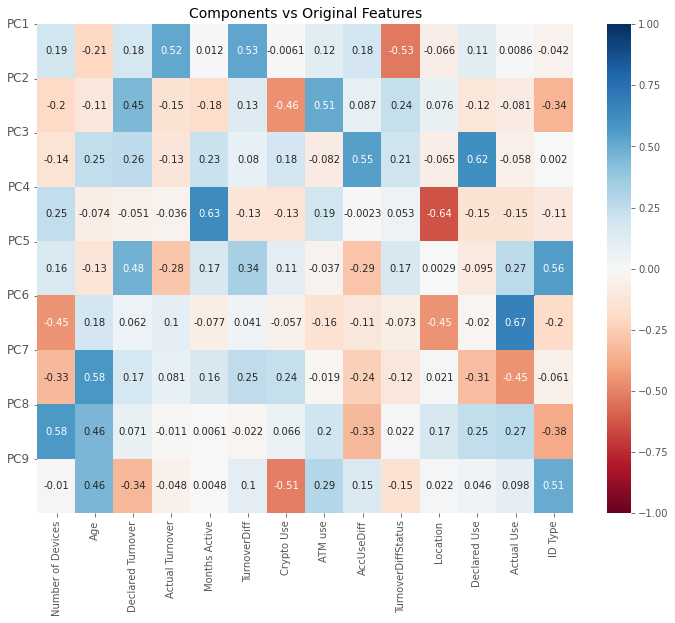

In [67]:
plt.figure(figsize=(12,9))
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2,3,4,5,6,7,8], 
           ['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9'],
           rotation = 0,
           fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

In [68]:
pca.transform(X_Scaled)
scores_pca = pca.transform(X_Scaled)

## Kmeans

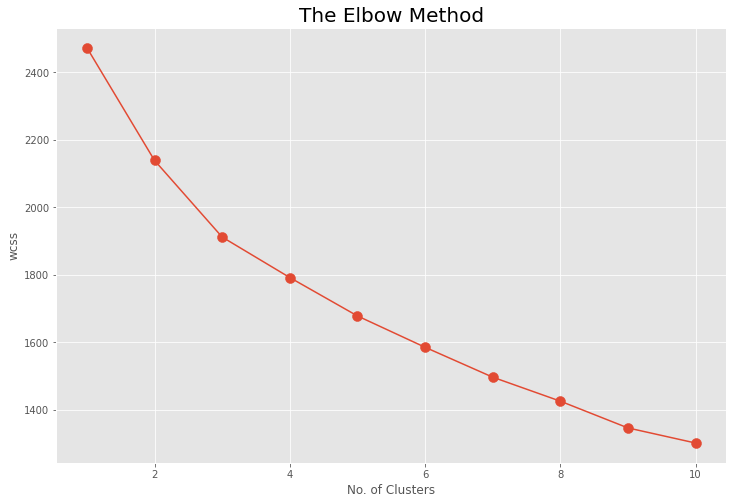

In [69]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i)
    km.fit_predict(scores_pca)
    wcss.append(km.inertia_)

# lets plot the results
plt.figure(figsize=((12,8)))
plt.plot(range(1, 11), wcss)
plt.scatter(range(1, 11), wcss ,s = 100)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

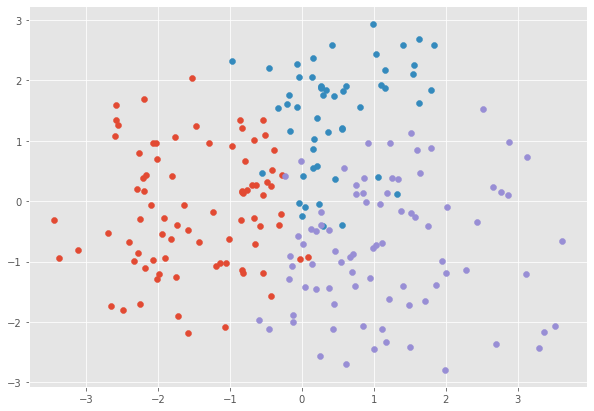

In [70]:
model = KMeans(n_clusters = 3, random_state = 19)
yhat = model.fit_predict(scores_pca)

# retrieve unique clusters
clusters = np.unique(yhat)

plt.figure(figsize = (10,7))
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(scores_pca[row_ix, 0], scores_pca[row_ix, 1])

# show the plot
plt.show()

In [71]:
set(yhat)

{0, 1, 2}

In [72]:
cleaned_data = pd.read_csv(path+"Cleaned_Data.csv")
cleaned_data

,Post code,ID Type,Email,Location,Number of Devices,Age,Crypto Use,ATM use,Declared Use,Declared Turnover,Actual Use,Actual Turnover,Months Active,Fraud Confirmed,AgeRange,TurnoverDiffStatus,TurnoverDiff,AccUseDiff,EmailDomain
0,W1,Passport,jbrekke@gmail.com,UK,3.0,18,YES,NO,Day to date,20,Day to date,20,12.0,NO,<30,Same,0,No,gmail.com
1,W2,Passport,sid23@verizon.net,Europe,3.0,19,YES,NO,Day to date,20,Day to date,30,3.0,NO,<30,High,10,No,verizon.net
2,W3,Passport,wstark@mac.com,Other,3.0,20,YES,NO,Day to date,20,Day to date,40,3.0,NO,<30,High,20,No,mac.com
3,W4,Passport,haven.gottlieb@comcast.net,High Risk Coutry,1.0,18,YES,NO,Day to date,20,ATM,20,3.0,YES,<30,Same,0,Yes,comcast.net
4,W5,ID Card,qheidenreich@msn.com,High Risk Coutry,1.0,18,NO,NO,Day to date,30,ATM,70,2.0,YES,<30,High,40,Yes,msn.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,W32,Driving licence Full,elinore.swaniawski@sbcglobal.net,UK,1.0,21,YES,NO,Receiving and Withdrawing,50,ATM,40,1.0,NO,<30,Low,10,Yes,sbcglobal.net
212,W33,Driving licence Provisional,fheller@yahoo.com,Europe,1.0,22,NO,NO,Day to date,20,Friends and Family,20,2.0,NO,<30,Same,0,Yes,yahoo.com
213,W34,Driving licence Provisional,predovic.syble@icloud.com,Other,3.0,21,NO,NO,Day to date,20,Receiving and Withdrawing,70,1.0,NO,<30,High,50,Yes,icloud.com
214,W35,Passport,hahn.vivienne@comcast.net,High Risk Coutry,2.0,27,NO,YES,ATM,20,ATM,100,1.0,NO,<30,High,80,No,comcast.net


In [73]:
clustered_data = cleaned_data.copy()
clustered_data["Cluster"] = yhat
clustered_data.head(10)

,Post code,ID Type,Email,Location,Number of Devices,Age,Crypto Use,ATM use,Declared Use,Declared Turnover,Actual Use,Actual Turnover,Months Active,Fraud Confirmed,AgeRange,TurnoverDiffStatus,TurnoverDiff,AccUseDiff,EmailDomain,Cluster
0,W1,Passport,jbrekke@gmail.com,UK,3.0,18,YES,NO,Day to date,20,Day to date,20,12.0,NO,<30,Same,0,No,gmail.com,0
1,W2,Passport,sid23@verizon.net,Europe,3.0,19,YES,NO,Day to date,20,Day to date,30,3.0,NO,<30,High,10,No,verizon.net,2
2,W3,Passport,wstark@mac.com,Other,3.0,20,YES,NO,Day to date,20,Day to date,40,3.0,NO,<30,High,20,No,mac.com,2
3,W4,Passport,haven.gottlieb@comcast.net,High Risk Coutry,1.0,18,YES,NO,Day to date,20,ATM,20,3.0,YES,<30,Same,0,Yes,comcast.net,0
4,W5,ID Card,qheidenreich@msn.com,High Risk Coutry,1.0,18,NO,NO,Day to date,30,ATM,70,2.0,YES,<30,High,40,Yes,msn.com,2
5,W6,ID Card,nconn@yahoo.ca,High Risk Coutry,3.0,18,NO,YES,Day to date,40,ATM,100,2.0,YES,<30,High,60,Yes,yahoo.ca,2
6,W7,ID Card,amos07@me.com,High Risk Coutry,2.0,31,NO,YES,ATM,20,ATM,20,2.0,NO,30-40,Same,0,No,me.com,0
7,W8,Residence permit,osinski.jeffery@icloud.com,High Risk Coutry,3.0,32,NO,YES,ATM,70,Friends and Family,20,2.0,NO,30-40,Low,50,Yes,icloud.com,1
8,W9,Residence permit,nitzsche.emerson@mac.com,Europe,2.0,31,NO,YES,ATM,100,Receiving and Withdrawing,20,6.0,NO,30-40,Low,80,Yes,mac.com,1
9,W10,Driving licence Full,bbahringer@live.com,Other,1.0,25,NO,YES,ATM,20,ATM,20,10.0,NO,<30,Same,0,No,live.com,0


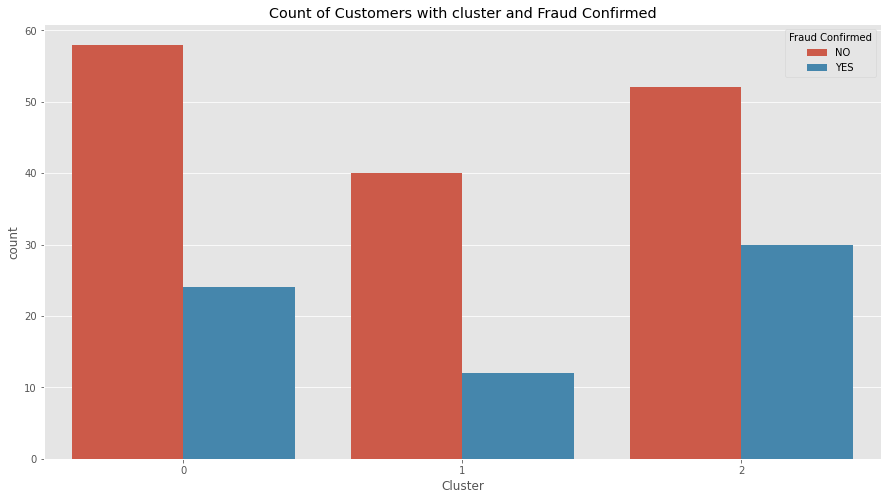

In [74]:
plt.figure(figsize=((15,8)))
ax = sns.countplot( x = 'Cluster', hue = 'Fraud Confirmed' , data = clustered_data)
plt.title(f"Count of Customers with cluster and Fraud Confirmed")
plt.show()

### From the above plot , There are more number of customers in cluster 2 with fraud confirmed, followed by cluster 0 and cluster 1. <br> From that we can assume 
- cluster0 = medium risk
- cluster1 = low risk
- cluster2 = high risk

### Let's Explore other parameters

In [75]:
def getbarplot(columnname):
    plt.figure(figsize=((15,8)))
    ax = sns.countplot( x = 'Cluster', hue = columnname, data = clustered_data)
    plt.title(f"Count of Customers with {columnname} and Clusters")
    plt.show()

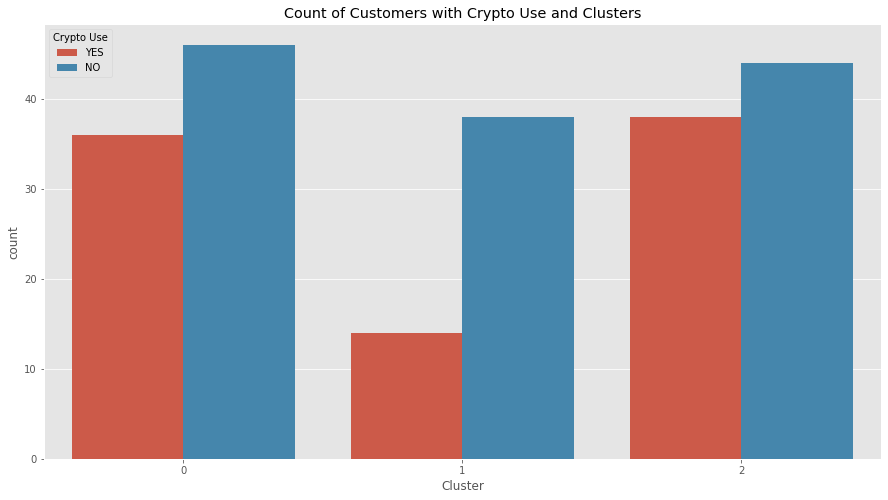

In [76]:
getbarplot('Crypto Use')

### Cluster 2 has highest number customers using Crypto, then cluster0 and minimum for cluster1 Hence by previous conclusions and this one, we can again claim about risk level of customers and cluster that
- cluster0 = medium risk
- cluster1 = low risk
- cluster2 = high risk

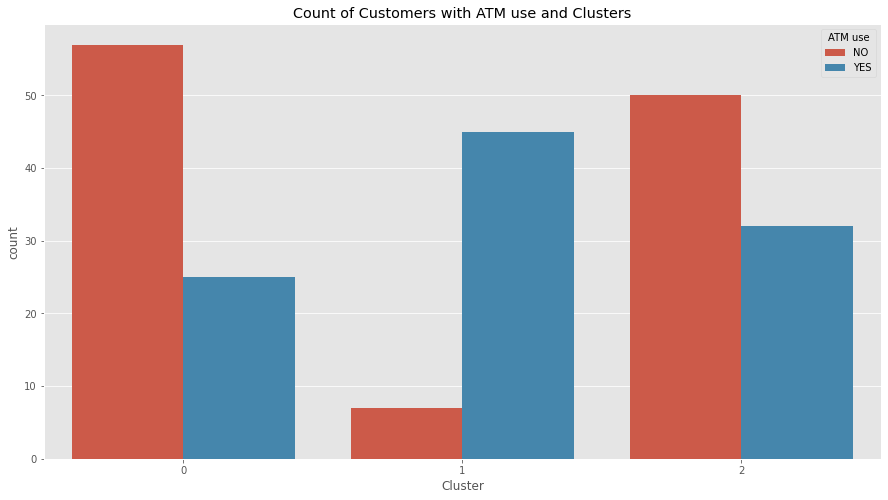

In [77]:
getbarplot('ATM use')

### From the above plot we can see that, There are more number of customers in cluster 1 who use ATM. <br> Nowadays most of the people use ATM and not all people commit fraud, so the above results are obvious.<br> We can say that 
- cluster0 = medium risk
- cluster1 = low risk
- cluster2 = high risk

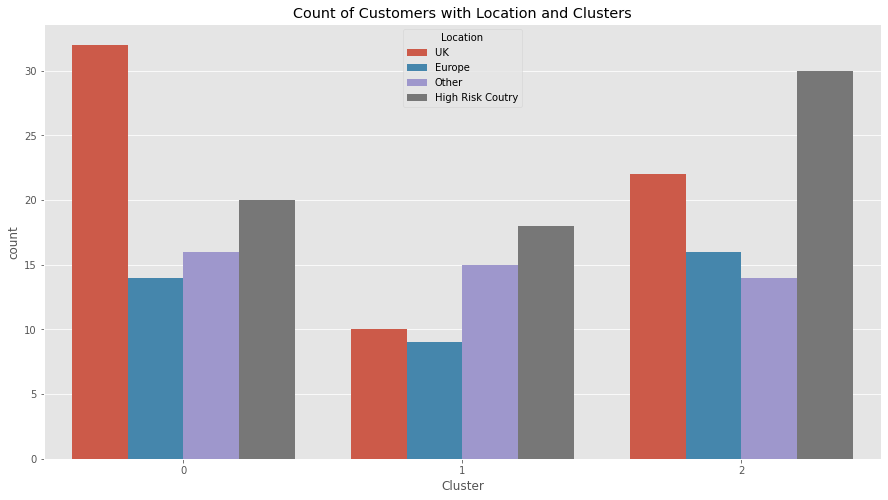

In [78]:
getbarplot('Location')

In [79]:
clustered_data[clustered_data['Location'] == "UK "][["Fraud Confirmed"]].value_counts(normalize=True).mul(100)

Fraud Confirmed
NO                 73.4375
YES                26.5625
dtype: float64

### Above plots shows that cluster 2 contains most of the people having location as "High Risk Country".<br> Cluster 1 and 0 have nearly equal in count. <br> Around 73% people from UK have not commited fraud. So from these values we can say that
- cluster0 = medium risk
- cluster1 = low risk
- cluster2 = high risk

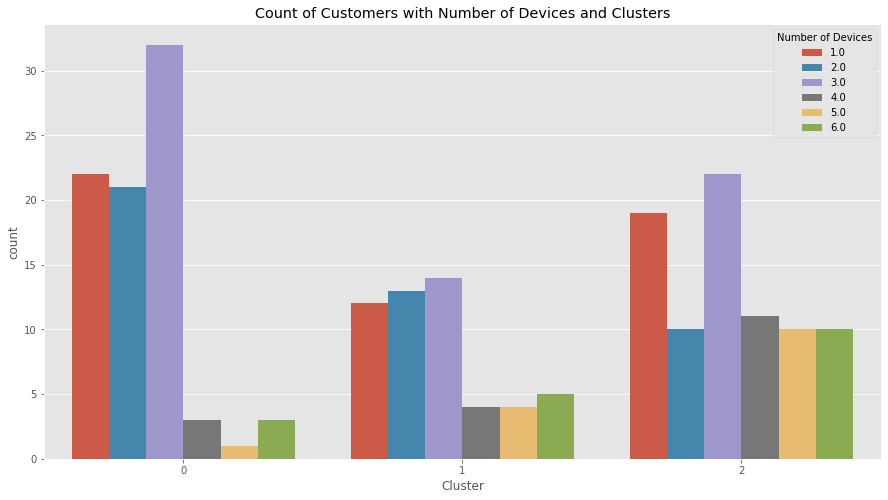

In [80]:
getbarplot("Number of Devices")

### More the no of devices connected, higher the chance of confirming fraud. <br> It is observed that in cluster 2 , there are more no of customers having 4+ devices connected, followed by cluster 1 and cluster 0. <br>Also fraud can be done with a single device. Cluster 0 and 2 have nearly same number of customers with 1 device. <br> Cluster 1 has less people. <br>Hence it indicates. 
- cluster0 = low risk
- cluster1 = medium risk
- cluster2 = high risk

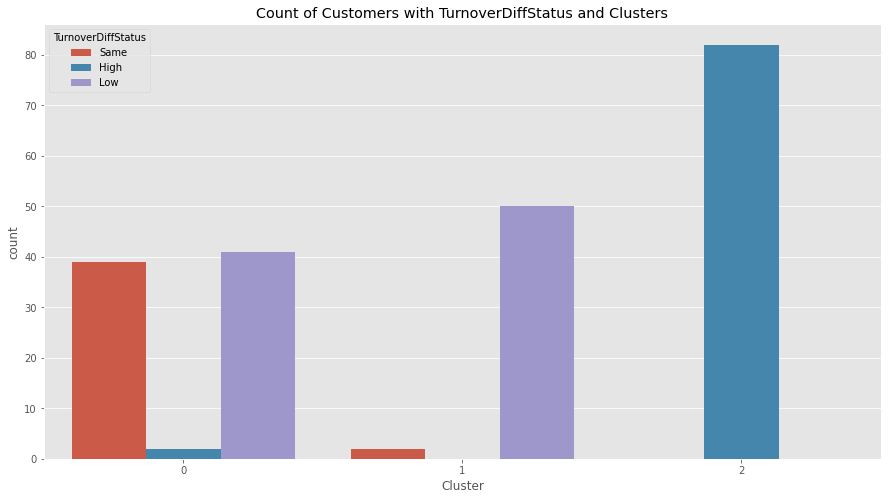

In [81]:
getbarplot("TurnoverDiffStatus")

### Difference between actual and declared turnover is an important feature. <br> In cluster 2 , All the people are have high difference between turnover, that can be the clear indication of fraud,<br> where cluster 0 has more no of customers with same turnover, those can be low risky customers with stable turnover. Thus
- cluster0 = low risk
- cluster1 = medium risk
- cluster2 = high risk

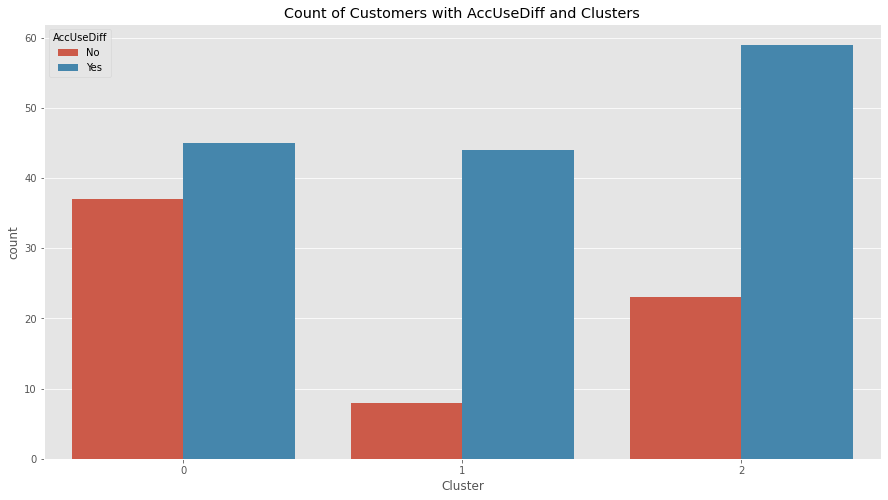

In [82]:
getbarplot("AccUseDiff")

### Cluster 2 contains most of the customer who are actually using their account for other purpose than the declared use. Those can be risky customers Hence
- cluster0 = medium risk
- cluster1 = low risk
- cluster2 = high risk


## From the Above Conclusions, We have found that most of the results are indicating 
- Cluster 2 customers as High risky customers, 
- Cluster 1 as low risky customers and 
- Customers in Cluster 0 with medium level of risk. 

### Creating Model for the same.

# Machine Learning

In [83]:
numeric_data = pd.read_csv(path+"Numeric_Data.csv")
numeric_data

,Number of Devices,Age,Declared Turnover,Actual Turnover,Months Active,TurnoverDiff,Crypto Use,ATM use,AccUseDiff,Fraud Confirmed,TurnoverDiffStatus,Location,Declared Use,Actual Use,ID Type
0,3.0,18,20,20,12.0,0,1,0,0,0,2,3,1,1,3
1,3.0,19,20,30,3.0,10,1,0,0,0,0,0,1,1,3
2,3.0,20,20,40,3.0,20,1,0,0,0,0,2,1,1,3
3,1.0,18,20,20,3.0,0,1,0,1,1,2,1,1,0,3
4,1.0,18,30,70,2.0,40,0,0,1,1,0,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1.0,21,50,40,1.0,10,1,0,1,0,1,3,3,0,0
212,1.0,22,20,20,2.0,0,0,0,1,0,2,0,1,2,1
213,3.0,21,20,70,1.0,50,0,0,1,0,0,2,1,3,1
214,2.0,27,20,100,1.0,80,0,1,0,0,0,1,0,0,3


In [84]:
numeric_data.columns

Index(['Number of Devices', 'Age', 'Declared Turnover', 'Actual Turnover',
       'Months Active', 'TurnoverDiff', 'Crypto Use', 'ATM use', 'AccUseDiff',
       'Fraud Confirmed', 'TurnoverDiffStatus', 'Location', 'Declared Use',
       'Actual Use', 'ID Type'],
      dtype='object')

In [90]:
X = numeric_data.copy() # Cluster is our target variable
y = clustered_data["Cluster"].copy()

In [91]:
X

,Number of Devices,Age,Declared Turnover,Actual Turnover,Months Active,TurnoverDiff,Crypto Use,ATM use,AccUseDiff,Fraud Confirmed,TurnoverDiffStatus,Location,Declared Use,Actual Use,ID Type
0,3.0,18,20,20,12.0,0,1,0,0,0,2,3,1,1,3
1,3.0,19,20,30,3.0,10,1,0,0,0,0,0,1,1,3
2,3.0,20,20,40,3.0,20,1,0,0,0,0,2,1,1,3
3,1.0,18,20,20,3.0,0,1,0,1,1,2,1,1,0,3
4,1.0,18,30,70,2.0,40,0,0,1,1,0,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1.0,21,50,40,1.0,10,1,0,1,0,1,3,3,0,0
212,1.0,22,20,20,2.0,0,0,0,1,0,2,0,1,2,1
213,3.0,21,20,70,1.0,50,0,0,1,0,0,2,1,3,1
214,2.0,27,20,100,1.0,80,0,1,0,0,0,1,0,0,3


In [92]:
y

0      0
1      2
2      2
3      0
4      2
      ..
211    0
212    0
213    2
214    2
215    2
Name: Cluster, Length: 216, dtype: int32

In [93]:
y.value_counts()

0    82
2    82
1    52
Name: Cluster, dtype: int64

In [94]:
class_weight = {0:1 ,1:1,2:1.5}

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True , stratify=y)

print("The Shape of X_train:", X_train.shape)
print("The Shape of X_test:", X_test.shape)
print("The Shape of y_train:", y_train.shape)
print("The Shape of y_test:", y_test.shape)
print("\n\n---------------------------------------------------------------------------------\n\n")

models = []
models.append(('LogisticRegression', LogisticRegression(random_state=0 , class_weight=class_weight)))
models.append(('GaussianNB'   , GaussianNB()))
models.append(('SVM'  , SVC(random_state=0 ,probability=True , class_weight=class_weight)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=0 , class_weight=class_weight)))
models.append(('XGBClassifier', XGBClassifier(random_state=0)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=0 )))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state=0 , class_weight=class_weight)))


model_name = []
train_accuracy = []
test_accuracy = []

for name, model in models: 
    
    model.fit(X_train,y_train)
    model_name.append(name)
    train_accuracy.append(model.score(X_train, y_train))
    test_accuracy.append(model.score(X_test, y_test))
    print("Done" + name)
Accuracy_df = pd.DataFrame({"Model" : model_name , "train_accuracy" : train_accuracy, "test_accuracy" : test_accuracy})
Accuracy_df

The Shape of X_train: (151, 15)
The Shape of X_test: (65, 15)
The Shape of y_train: (151,)
The Shape of y_test: (65,)


---------------------------------------------------------------------------------


DoneLogisticRegression
DoneGaussianNB
DoneSVM
DoneDecisionTreeClassifier
DoneXGBClassifier
DoneGradientBoostingClassifier
DoneKNeighborsClassifier
DoneRandomForestClassifier


,Model,train_accuracy,test_accuracy
0,LogisticRegression,1.000000,0.969231
1,GaussianNB,0.966887,0.938462
2,SVM,0.927152,0.830769
3,DecisionTreeClassifier,1.000000,0.907692
4,XGBClassifier,1.000000,0.953846
5,GradientBoostingClassifier,1.000000,0.969231
6,KNeighborsClassifier,0.960265,0.830769
7,RandomForestClassifier,1.000000,0.953846


                        Model  train_accuracy  test_accuracy
2                         SVM        0.920530       0.784615
6        KNeighborsClassifier        0.927152       0.815385
0          LogisticRegression        1.000000       0.938462
1                  GaussianNB        0.973510       0.953846
3      DecisionTreeClassifier        1.000000       0.953846
4               XGBClassifier        1.000000       0.969231
5  GradientBoostingClassifier        1.000000       0.969231
7      RandomForestClassifier        1.000000       0.969231


<BarContainer object of 8 artists>

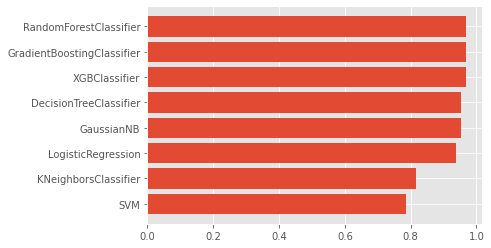

In [ ]:
Temp = Accuracy_df.sort_values("test_accuracy")
print(Temp)
plt.barh( Temp["Model"],Temp["test_accuracy"] )

In [96]:
def NormalizedModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()
    elif nameOfScaler == 'normalizer':
        scaler = Normalizer()
    elif nameOfScaler == 'binarizer':
        scaler = Binarizer()

    pipelines = []
    pipelines.append((nameOfScaler+'_LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression(class_weight=class_weight))])))
    pipelines.append((nameOfScaler+'_KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'_DT'  , Pipeline([('Scaler', scaler),('DT'  , DecisionTreeClassifier(class_weight=class_weight))])))
    pipelines.append((nameOfScaler+'_NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'_SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'_XGB' , Pipeline([('Scaler', scaler),('XGB' , XGBClassifier())])  ))
    pipelines.append((nameOfScaler+'_GBM' , Pipeline([('Scaler', scaler),('GBM' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'_RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier(class_weight=class_weight))])  ))

    return pipelines

# Train model
def fit_model(X_train, y_train, X_test , y_test ,models):
    
    num_folds = 10
    scoring = 'accuracy'

    model_name = []
    train_accuracy = []
    test_accuracy = []

    for name, model in models: 
        
        model.fit(X_train,y_train)
        model_name.append(name)
        train_accuracy.append(model.score(X_train, y_train))
        test_accuracy.append(model.score(X_test, y_test))
        print("Done" + name)
        Accuracy_df = pd.DataFrame({"Model" : model_name , "train_accuracy" : train_accuracy, "test_accuracy" : test_accuracy})
    print(Accuracy_df)
    return Accuracy_df

In [97]:
ScaledModel = NormalizedModel('standard')
df = fit_model(X_train, y_train, X_test , y_test, ScaledModel)

Donestandard_LR
Donestandard_KNN
Donestandard_DT
Donestandard_NB
Donestandard_SVM
Donestandard_XGB
Donestandard_GBM
Donestandard_RF
          Model  train_accuracy  test_accuracy
0   standard_LR        1.000000       1.000000
1  standard_KNN        0.953642       0.892308
2   standard_DT        1.000000       0.876923
3   standard_NB        0.966887       0.938462
4  standard_SVM        1.000000       0.984615
5  standard_XGB        1.000000       0.953846
6  standard_GBM        1.000000       0.969231
7   standard_RF        1.000000       0.953846


          Model  train_accuracy  test_accuracy
2   standard_DT        1.000000       0.876923
1  standard_KNN        0.953642       0.892308
3   standard_NB        0.966887       0.938462
5  standard_XGB        1.000000       0.953846
7   standard_RF        1.000000       0.953846
6  standard_GBM        1.000000       0.969231
4  standard_SVM        1.000000       0.984615
0   standard_LR        1.000000       1.000000


<BarContainer object of 8 artists>

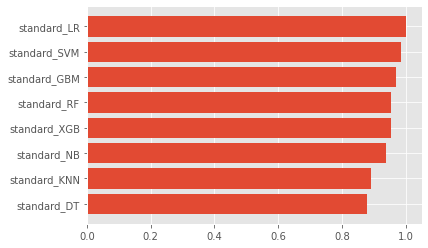

In [98]:
Temp = df.sort_values("test_accuracy")
print(Temp)
plt.barh( Temp["Model"],Temp["test_accuracy"] )

In [99]:
finalmodels = []

finalmodels.append(('RF' , Pipeline([('RF', RandomForestClassifier(class_weight=class_weight))])))
finalmodels.append(('XGB' , Pipeline([('XGB', XGBClassifier())])))
finalmodels.append(('GBM' , Pipeline([('GBM', GradientBoostingClassifier())])))
finalmodels.append(('DT' , Pipeline([('DT', DecisionTreeClassifier(class_weight=class_weight))])))
finalmodels.append(('LR' , Pipeline([('LR', LogisticRegression(class_weight=class_weight))])))


finalmodels.append(('std_RF' , Pipeline([('Scaler' ,StandardScaler()), ('RF', RandomForestClassifier(class_weight=class_weight))])))
finalmodels.append(('std_SVM' , Pipeline([('Scaler' ,StandardScaler()), ('SVM' , SVC())])))
finalmodels.append(('std_XGB' , Pipeline([('Scaler' ,StandardScaler()), ('XGB' , XGBClassifier())])))
finalmodels.append(('std_GBM' , Pipeline([('Scaler' ,StandardScaler()), ('GBM', GradientBoostingClassifier())])))
finalmodels.append(('std_DT' , Pipeline([('Scaler' ,StandardScaler()), ('DT' , DecisionTreeClassifier(class_weight=class_weight))])))
finalmodels.append(('std_LR' , Pipeline([('Scaler' ,StandardScaler()), ('LR' , LogisticRegression(class_weight=class_weight))])))


In [100]:
# Metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score        


# pipeline = make_pipeline(MinMaxScaler(),  LogisticRegression())
for name, model in finalmodels:
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\n*****************************************************************************")
    print(name)
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score :{accuracy_score(y_test, y_pred) * 100:.1f}%")

    print(classification_report(y_test, y_pred))


*****************************************************************************
RF
Training Accuracy Score: 100.0%
Validation Accuracy Score :96.9%
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       0.88      1.00      0.94        15
           2       1.00      1.00      1.00        25

    accuracy                           0.97        65
   macro avg       0.96      0.97      0.97        65
weighted avg       0.97      0.97      0.97        65


*****************************************************************************
XGB
Training Accuracy Score: 100.0%
Validation Accuracy Score :95.4%
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.93      0.87      0.90        15
           2       1.00      1.00      1.00        25

    accuracy                           0.95        65
   macro avg       0.95      0.94      0.95        6

## Clearly standardized LR Model is perfoming good if we observe f1, precision and recall values.

# Retraining Model with 100% data & Saving Models as Serilized File

In [101]:
import pickle
import os

pipeline = make_pipeline(StandardScaler(),  LogisticRegression(class_weight=class_weight))
model = model.fit(X, y)
with open( path+f'Std_LR_model.pkl', 'wb') as fileWriteStream:
    pickle.dump(model, fileWriteStream)
    # Don't forget to close the filestream!
    fileWriteStream.close()

## Sample Data Prediction

In [114]:
customer_no = 212
X.iloc[customer_no] , y.iloc[customer_no]

(Number of Devices      1.0
 Age                   22.0
 Declared Turnover     20.0
 Actual Turnover       20.0
 Months Active          2.0
 TurnoverDiff           0.0
 Crypto Use             0.0
 ATM use                0.0
 AccUseDiff             1.0
 Fraud Confirmed        0.0
 TurnoverDiffStatus     2.0
 Location               0.0
 Declared Use           1.0
 Actual Use             2.0
 ID Type                1.0
 Name: 212, dtype: float64, 0)

## For customer no 212 , it is in cluster 0. <br> Let's see what our model predicts.

In [115]:

sample = X.iloc[customer_no]
single_sample = np.array(sample).reshape(1,-1)
pred = model.predict(single_sample)
print(pred.item())
print(max(model.predict_proba(single_sample)[0]))
print((model.predict_proba(single_sample)[0]))

0
0.9994203014864941
[9.99420301e-01 1.17230365e-04 4.62468148e-04]


### Here we are getting output as 0, that means this customer belong to Cluster 0 <br> If we look at the probabilities it is clear that 99.94% , model is sure that this customer belong to cluster 0.



# Final Conclusion :

1. From the analysis we did before, We were successfully able to decide the risk level of customers given some parameters.
2. With K-Means clustring algorithm , we achieved to segregate customers into 3 clusters as following:

  - Cluster 2 => High risk level customers
  - Cluster 1 => Low risk level customers 
  - Cluster 0 => Medium risk level customers 

3. Then with the help of machine learning, Linear Regression Model is able to predict the risk level with 100% accuracy if the desired attributes of the customer are provided. 
4. From the above analysis, the important attributes were 
  - Actual Turnover
  - Declared Turnover
  - Number of Devices
  - Crypto Use
  - ATM use
  - Actual Use
  - Location
  - Months active
5. More attributes were invented with the help of above attributes during the analysis. e.g.
  - Turnover difference
  - Actual turnover is high / low / same than declared turnover.
  - Actual use and delclared use are same or not.
  - Age Groups were created to analyze the data.
6. The attributes like Age, Post code and ID type were not much useful in the analysis. If more details can be collected about these factors then may be we can find some pattern that helps to predict fraud.
7. Data collected from Time to time feedback from customers about service will definetly help us to understand the customer more. 

We proposed a model using K-Means Clusturing algorithm for customer segmentation to divide customers into different risk levels and classification model for prediction of the risk level of particular customer.<br>
We were able to conclude by in depth analysis of various features like - 
  - Actual Turnover
  - Declared Turnover
  - Number of Devices
  - Crypto Use
  - ATM use
  - Actual Use
  - Location
  - Months active <br>


Also we were able to create more features using feature engieering to get more insights from data. The new invented features were - 
  - Turnover difference
  - Actual turnover is high / low / same than declared turnover.
  - Actual use and delclared use are same or not.
  - Age Groups were created to analyze the data.


Other attributes can be considered are 
- Gender
- Loan details
- Credit score (e.g. Cibil - India , Shufa - Germany)
- Employment history
- Family Details
- Tax clearances
- Insurance Details
- Crime Records


